# Lecture 18: Training Neural Networks
***

<img src="figs/nnbanner.png",width=1100,height=50>

**Reminder**: Scroll down and shift-enter the **Helper Functions** at the bottom of the notebook.  

### Problem 1: Implementing Back Propagation 
***

In this exercise you will fill in some blanks in a neural net code to implement back propagation.

Scroll down to the Helper Functions and look at the Network class. 

The class allows you to specify the architecture of your feed forward network using list of network sizes.  By default, I've hard-coded sigmoid activation functions and a squared loss cost function.  Your job is to familiarize yourself with the class, and fill in the blanks in the $\texttt{back_prop}$ method. 

When you think that your $\texttt{back_prop}$ routine is correct, you can test it on a simple target application of classifying point in two-dimensional space.  The following code cell initializes a network with $2$ neurons in the input layer, $4$ neurons in a single hidden layer, and $2$ output neurons corresponding to the two potential classes. 

Upon executing the cell you can also see a plot of a realization of the training set. 


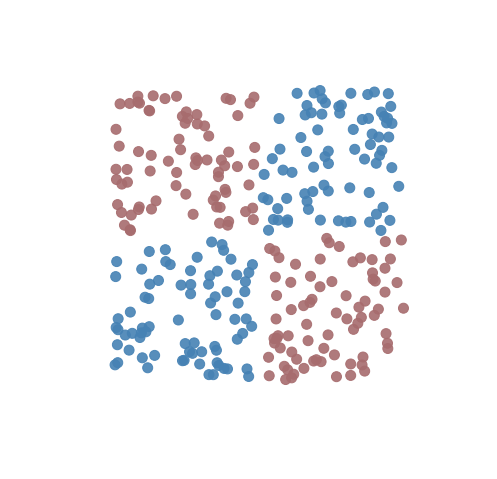

In [17]:
nn = Network([2,4,2])
X_train, y_train = generate_data(300, "checkerboard") # Check out other available data configurations 
nn.pretty_pictures(X_train, y_train, decision_boundary=False)

When you think your $\texttt{back_prop}$ routine is correct, execute the following code cell to train your network. Note that I've set the initial number of epochs to $150$, the learning rate $\eta = 0.1$, and the visualization to False. 

In [18]:
nn.SGD_train(X_train, y_train, epochs=5, eta=0.1, vis=False)

Epoch    1: Train    0.50000


If you're fairly certain your SGD is converging, try turning on the visualization features of the output.  This will produce a snapshot of the NN decision boundary as the learning progresses. Don't forget to reinitialize your network if you want to start from scratch. 

In [ ]:
nn = Network([2,4,2])
nn.SGD_train(X_train, y_train, epochs=150, eta=0.1, vis=True)

OK, now try messing with some parameters, like the SGD learning rate and the number of hidden layers and neurons. 

### Problem 2: Implementing Gradient Checking 
***

Due to the fact that we hard-code our various activation functions, cost functions, and their derivatives, it is vital to do some debugging to make sure we haven't made a mistake.  

One common technique is to do numerical gradient checking.  In this method we compute numerical approximations of the derivatives of the cost function with respect to the model parameters and compare them to the analytic(ish) versions computed by back prop.  

Consider a cost function $C$ which is a function of all of the weights and biases in the network.  We can estimate the derivative of $C$ with respect to a particular parameter using a numerical finite difference technique.  This process looks as follows 

$$
\frac{\partial C}{\partial w_i} \approx \frac{C(w_1,\ldots, w_i+\epsilon, \ldots w_N) - C(w_1,\ldots, w_i-\epsilon, \ldots w_N)}{2\epsilon}
$$

Evaluating the cost function with the perturbed weights can be accomplished by randomly choosing a training example, performing forward propagation, and then evaluating the cost function using the activations in the output layer.  

I've given you starter code down below to do numerical gradient checking.  The code will compute the true and numerical values of the derivative of $C$ with respect to each parameter in the network and then plot the pairs of values as well as their relative errors.  Note that in practice this is extremely expensive, and we typically only check a few random parameters. 

When you believe your code is correct, you can test it by executing the following code. Note that a good rule of thumb is to train the network for a handful of epochs before doing the gradient checking, to avoid any transient behavior that might occur at the very beginning of the training process. 

In [19]:
nn.gradient_checking(X_train, y_train, EPS=0.0001)

NameError: global name 'true_dW' is not defined

<br><br><br><br>
<br><br><br><br>
<br><br><br><br>

### Helper Functions
***

In [15]:
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt
from matplotlib.colors import colorConverter, ListedColormap
%matplotlib inline

class Network:
    def __init__(self, sizes):
        self.L = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(n, 1) for n in self.sizes[1:]]
        self.weights = [np.random.randn(n, m) for (m,n) in zip(self.sizes[:-1], self.sizes[1:])]
        
    def g(self, z):
        """
        activation function 
        """
        return sigmoid(z)
    
    def g_prime(self, z):
        """
        derivative of activation function 
        """
        return sigmoid_prime(z) 
    
    def forward_prop(self, a):
        """
        memory aware forward propagation for testing 
        only.  back_prop implements it's own forward_prop 
        """
        for (W,b) in zip(self.weights, self.biases):
            a = self.g(np.dot(W, a) + b) 
        return a
    
    def gradC(self, a, y):
        """
        gradient of cost function 
        Assumes C(a,y) = (a-y)^2/2 
        """
        return (a - y)
    
    def SGD_train(self, X_train, y_train, epochs, eta, vis=False, X_test=None, y_test=None):
        """
        SGD for training parameters 
        If test set is provided, routine will print accuracy on test set as learning evolves
        If vis is set to True then the final output will print a sequence of images showing the 
        evolving decision boundary.  WARNING:  This makes the code MUCH slower.  
        """
        n_train = X_train.shape[0]
        for epoch in range(epochs):
            perm = np.random.permutation(X_train.shape[0])
            for kk in range(n_train):
                xk = X_train[perm[kk],:].reshape((-1,1))
                yk = y_train[perm[kk],:].reshape((-1,1))
                dWs, dbs = self.back_prop(xk, yk)
                self.weights = [W - eta*dW for (W, dW) in zip(self.weights, dWs)]
                self.biases = [b - eta*db for (b, db) in zip(self.biases, dbs)]
            if epoch==0 or (epoch + 1) % 50 == 0:
                acc_train = self.evaluate(X_train, y_train)
                if vis:
                    self.pretty_pictures(X_train, y_train, decision_boundary=True, epoch=epoch+1)
                if X_test is not None:
                    acc_test = self.evaluate(X_test, y_test)
                    print "Epoch {:4d}: Train {:10.5f}, Test {:10.5f}".format(epoch+1, acc_train, acc_test) 
                else:
                    print "Epoch {:4d}: Train {:10.5f}".format(epoch+1, acc_train)    
                
    def back_prop(self, x, y):
        """
        Back propagation for derivatives of C wrt parameters 
        """
        
        # Initialize list of derivatives wrt to biases and weights
        db_list = [np.zeros(b.shape) for b in self.biases]
        dW_list = [np.zeros(W.shape) for W in self.weights]
        
        a = x                            # Initalize input activation  
        a_list = [a]                     # Put input activation in activation list 
        z_list = [np.zeros(a.shape)]     # Pad with throwaway so indices match 
        
        # Forward propagate to get activations and 
        # activities on each layer 
        for W, b in zip(self.weights, self.biases):
            z = np.dot(W, a) + b 
            z_list.append(z)
            a = self.g(z)
            a_list.append(a)
            
        # Back propagate deltas to compute derivatives 
        # TODO delta  = 
        for ell in range(self.L-2,-1,-1):
            # TODO db_list[ell] = 
            # TODO dW_list[ell] = 
            # TODO delta = 
            pass 
        
        return (dW_list, db_list)
    
    def evaluate(self, X, y):
        """
        Evaluate current model on labeled test data 
        """
        ctr = 0 
        for kk in range(X.shape[0]):
            xk = X[kk,:].reshape((-1,1))
            yk = y[kk,:].reshape((-1,1))
            yhat = self.forward_prop(xk)
            ctr += np.argmax(yhat) == np.argmax(yk) 
        return float(ctr) / float(X.shape[0])
    
    def compute_cost(self, x, y):
        """
        Evaluate the cost function for a specified 
        training example. 
        """
        a = self.forward_prop(x)
        return 0.5*np.linalg.norm(a-y)**2
    
    def pretty_pictures(self, X, y, decision_boundary=True, epoch=None):
        """
        Function to plot data and decision boundary
        """
        
        mycolors = {"blue": "steelblue", "red": "#a76c6e"}
        colorlist = [c for (n,c) in mycolors.items()]
        colors = [colorlist[np.argmax(yk)] for yk in y ]

        fig = plt.figure(figsize=(8,8))
        ax = fig.add_subplot(111) 
        
        if decision_boundary:
            x_min, x_max = -1, 1
            y_min, y_max = -1, 1
            xx, yy = np.meshgrid(np.arange(x_min, x_max, .005), np.arange(y_min, y_max, .005))
            Xgrid = np.vstack((xx.ravel(), yy.ravel())).transpose()
            one_hot_pred = [self.forward_prop(xk.reshape((-1,1))) for xk in Xgrid]
            Z = np.array([np.argmax(p) for p in one_hot_pred])
            Z = Z.reshape(xx.shape)
            cmap = ListedColormap([
                colorConverter.to_rgba('steelblue', alpha=0.30),
                colorConverter.to_rgba('#a76c63', alpha=0.30)])
            plt.contourf(xx, yy, Z, cmap=cmap)
            acc = self.evaluate(X, y)
            txtstring = 'acc = ' + str(acc)[:5]
            height = 0.90
            if epoch: 
                txtstring += '\nepoch = ' + str(epoch)
                height -= 0.05
            plt.text(-.98,height, txtstring, fontsize=16)

        plt.scatter(X[:,0], X[:,1], color=colors, s=100, alpha=0.9)
        plt.axis('off')
        
    def gradient_checking(self, X_train, y_train, EPS=0.0001):
        """
        Performs gradient checking on all weights in the 
        network for a randomly selected training example 
        """
        # Randomly select a training example 
        kk = np.random.randint(0,X_train.shape[0])
        xk = X_train[kk,:].reshape((-1,1))
        yk = y_train[kk,:].reshape((-1,1))

        # Get the analytic(ish) weights from back_prop 
        dWs, dbs = self.back_prop(xk, yk)
        
        # Loop over and perturb each weight/bias in 
        # network and test numerical derivative 
        # Don't forget that after perturbing the weights
        # you'll want to put them back the way they were! 
        
        # Loop over each layer 
        for ell in range(self.L-1):
            # Loop over the rows of W and b 
            for ii in range(self.weights[ell].shape[0]):
                # Loop over the columns of W and check W[ell][ii,jj] 
                for jj in range(self.weights[ell].shape[1]):
                    # TODO true_dW = 
                    # TODO num_dW = 
                    print "w: {: 10.8e}  {: 10.8e} {: 10.8e}".format(true_dW, num_dW, 
                                                                     np.abs(true_dW-num_dW)/np.abs(true_dW))
                # Check bias b[ell][ii]
                
                # TO DO true_db = 
                # TO DO num_db = 
                print "b: {: 10.8e}  {: 10.8e} {: 10.8e}".format(true_db, num_db, 
                                                                 np.abs(true_db-num_db)/np.abs(true_db))
                
def sigmoid(z):
    return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
    return sigmoid(z) * (1.0 - sigmoid(z))

def generate_data(N, config="checkerboard"):
    X = np.zeros((N,2))
    y = np.zeros((N,2)).astype(int)
    
    if config=="checkerboard":
        for kk in xrange(N/2):
            sample = 0.95*np.random.rand(2)+.025
            sample *= -1 if kk%2==0  else 1 
            X[kk,:] = sample
            y[kk,:] = np.array([1,0])
        for kk in xrange(N/2,N):
            sample = 0.95*np.random.rand(2)+.025
            sample *= np.array([1,-1])
            sample *= -1 if kk%2==0  else 1 
            X[kk,:] = sample 
            y[kk,:] = np.array([0,1])
    
    if config=="circles":
        kk=0
        while kk < N/2:
            sample = 2*np.random.rand(2)-1 
            if np.linalg.norm(sample) <= .4:
                X[kk,:] = sample 
                y[kk,:] = np.array([1,0])
                kk += 1 
        while kk < N:
            sample = 2*np.random.rand(2)-1 
            dist = np.linalg.norm(sample)
            if dist < 0.9 and dist > 0.6:
                X[kk,:] = sample 
                y[kk,:] = np.array([0,1])
                kk += 1
                
    if config=="moons":
        X, yflat = datasets.make_moons(n_samples=N, noise=.05)
        X[:,0] = .5*(X[:,0]-.5)
        X[:,1] = X[:,1]-.25
        for kk, yk in enumerate(yflat):
            y[kk,:] = np.array([1,0]) if yk else np.array([0,1])
            
    return X, y

from IPython.core.display import HTML
HTML("""
<style>
.MathJax nobr>span.math>span{border-left-width:0 !important};
</style>
""")